In [1]:
import pandas as pd

In [20]:
# !pip install PyPortfolioOpt

In [4]:
df = pd.read_csv('../data/mvp_data.csv', parse_dates=True, index_col=0)
df.columns = ['EUR', 'GOLD', 'Bitcoin', 'Apple', 'Exxon', 'VISA', 'Oil']
# заполним пропуски последними известными значениями, так как пропуски чаще всего - это праздничные периоды
# перейдем на недельный интервал и средним значениям на них
df_w = df.fillna(method='ffill').resample('W').ffill()
df_w.head(5)

,EUR,GOLD,Bitcoin,Apple,Exxon,VISA,Oil
Date,,,,,,,
2020-01-05,1.117144,1549.199951,7344.884277,72.735321,58.564049,185.520187,63.049999
2020-01-12,1.111111,1557.500000,8166.554199,75.889969,57.573124,189.600433,59.040001
2020-01-19,1.113958,1558.800049,8929.038086,77.944138,57.090160,200.295197,58.540001
2020-01-26,1.105522,1571.099976,8445.434570,77.841423,55.224911,200.588791,54.189999
2020-02-02,1.102913,1582.900024,9350.529297,75.689430,51.727554,194.688538,51.560001


In [5]:
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter

In [7]:
#Годовая доходность
mu = expected_returns.mean_historical_return(df_w) 
#Дисперсия портфеля
Sigma = risk_models.sample_cov(df_w)
#Максимальный коэффициент Шарпа
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #
sharpe_pfolio = ef.max_sharpe() #
sharpe_pwt = ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('EUR', 0.0), ('GOLD', 0.0), ('Bitcoin', 0.15661), ('Apple', 0.51066), ('Exxon', 0.33274), ('VISA', 0.0), ('Oil', 0.0)])


In [8]:
# общие характеристики по портфелю
ef.portfolio_performance(verbose=True)

Expected annual return: 179.9%
Annual volatility: 63.8%
Sharpe Ratio: 2.79


(1.7989694511886427, 0.6381682984299708, 2.7876180242191353)

In [31]:
# посмотрим портфель, который показывает минимальную волатильность
ef_1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
minvol = ef_1.min_volatility()
portf_minvol = ef_1.clean_weights()
print(portf_minvol)

OrderedDict([('EUR', 0.9177), ('GOLD', 0.07165), ('Bitcoin', 0.0), ('Apple', 0.0), ('Exxon', 0.0), ('VISA', 0.0), ('Oil', 0.01064)])


In [33]:
# ef_1.portfolio_performance(verbose=True, risk_free_rate = 0.25)

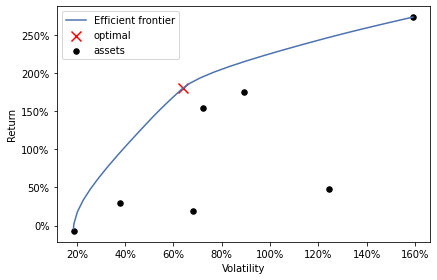

In [40]:
# визуализация эффективной границы
ax = pplt.plot_efficient_frontier(CLA(mu, Sigma), showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [42]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# портфель с минимальной волатильностью
latest_prices = get_latest_prices(df_w)
allocation_minvol, rem_minvol = DiscreteAllocation(portf_minvol, latest_prices, total_portfolio_value=1000000).lp_portfolio() 
print(allocation_minvol)
print("Осталось средств после построения портфеля с минимальной волатильностью - {:.2f} USD".format(rem_minvol))
print()

{'EUR': 861004, 'GOLD': 39, 'Apple': 1, 'Exxon': 1, 'VISA': 1, 'Oil': 133}
Осталось средств после построения портфеля с минимальной волатильностью - 15.46 USD



In [43]:
# портфель с максимальным коэффициентом Шарпа

allocation_shp, rem_shp = DiscreteAllocation(sharpe_pwt, latest_prices, total_portfolio_value=1000000).lp_portfolio() 
print(allocation_shp)
print("Осталось средств после построения портфеля с минимальной волатильностью - {:.2f} USD".format(rem_shp))

{'EUR': 1976, 'GOLD': 1, 'Bitcoin': 9, 'Apple': 3940, 'Exxon': 3045, 'VISA': 5, 'Oil': 14}
Осталось средств после построения портфеля с минимальной волатильностью - 47.47 USD


Итого, предлагается купить для оптимального портфеля (с учетом указанного капитала в 1 млн $):
- EUR - 1976,
- GOLD - 1,
- Биткоины - 9,
- акции Apple - 3940 шт,
- акции Exxon Mobile - 3045 шт,
- акции VISA - 5 шт,
- Сырая нефть - 14 баррелей,
- остаток - 47 USD

## Что сделать

- обеспечить дробную покупку, после этого снизить капитал
- сделать разделение на тест и валид
- улучшить графики